# RAG on simple QA collection

One of the common cases of RAG-systems and RAG-based agents is to try to answer to user's input based on FAQ or similar QA-dataset.

While it's possible to vectorize the whole QA-collection, it might be ineffective.

This notebooks explores a different approach to vectorization.
Only the questions are being vectorized, so agent / RAG tries to match the user's input with questsions, and then retrieves related answers.
Those answers are then being passed as a part of prompt to summarizer.

In [1]:
import sys

sys.path.append("src")

In [2]:
import simple_rag

print(simple_rag.__author__)

tmullayanov


## Preparing data

The data is generated by DeepSeek in the form of csv.
It's located at `assets/sample_qna.csv`, the delimiter is `;`

In [3]:
import pandas as pd

In [4]:
qna = "assets/sample_qna.csv"
qna_delimiter = ";"

csv = pd.read_csv(qna, delimiter=qna_delimiter)

In [5]:
csv.head()

,Вопрос,Ответ
0,Что такое Python?,Python - это высокоуровневый язык программиров...
1,Что такое Python?,"Он широко используется в веб-разработке, анали..."
2,Какие типы данных существуют в Python?,"Основные типы данных в Python: строки (str), ц..."
3,Какие типы данных существуют в Python?,"Также есть сложные типы данных, такие как спис..."
4,Что такое HTML?,HTML (HyperText Markup Language) - это стандар...


In [6]:
tag_question = "Вопрос"
tag_answer = "Ответ"


def build_qna_relation(qna_df: pd.DataFrame) -> dict[str, list[str]]:
    qna_db = {}
    for _, row in qna_df.iterrows():
        question = row[tag_question]
        answer = row[tag_answer]

        qna_db.setdefault(question, []).append(answer)

    return qna_db

In [7]:
db = build_qna_relation(csv)

In [8]:
print(db)

{'Что такое Python?': ['Python - это высокоуровневый язык программирования общего назначения с простым синтаксисом.', 'Он широко используется в веб-разработке, анализе данных, искусственном интеллекте и автоматизации.'], 'Какие типы данных существуют в Python?': ['Основные типы данных в Python: строки (str), целые числа (int), числа с плавающей точкой (float), булевы значения (bool).', 'Также есть сложные типы данных, такие как списки (list), кортежи (tuple), множества (set) и словари (dict).'], 'Что такое HTML?': ['HTML (HyperText Markup Language) - это стандартный язык разметки для создания веб-страниц.'], 'Что такое CSS?': ['CSS (Cascading Style Sheets) - это язык стилей, используемый для описания внешнего вида и форматирования документа HTML.'], 'Что такое JavaScript?': ['JavaScript - это язык программирования, который позволяет создавать интерактивные элементы на веб-сайтах.'], 'Что такое SQL?': ['SQL (Structured Query Language) - это язык программирования, используемый для управл

In [9]:
# Let's use helpers to simplify working with questions and answers.
# These helpers are a good point to derive 'interface' for objects later.

from typing import Optional


def get_questions(db: dict[str, list[str]]) -> list[str]:
    """
    Get list of questions in our Q&A database.
    These are the questions we have specialized answers to.
    """
    return db.keys()


def lookup_answers(db: dict[str, list[str]], question: str) -> Optional[list[str]]:
    """
    Get answers for a question from our Q&A database as a list of strings.
    If there is no such question, return None.
    """

    return db.get(question, None)

## Embeddings

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = InMemoryVectorStore(embeddings)

In [11]:
from langchain.docstore.document import Document

docs = [
    Document(page_content=s, metadata={"source": "local_qna"})
    for s in get_questions(db)
]

In [12]:
doc_ids = vector_store.add_documents(docs)

In [13]:
doc_ids

['5e6de2eb-0ad4-454d-874f-5c83aa886db0',
 '5669e0d7-bd77-4230-9f46-e9eb283c4af1',
 '1ead6ea3-7240-4c07-8eb6-621170ecaf01',
 'd7dbf2b9-e6c9-47cd-aba0-902e30d88077',
 'd97f0287-cb98-480b-89d5-80a6d3a77c90',
 '538f8549-af61-4b6e-9ef8-09e42216a781',
 'ed99ce9d-fb64-4ab2-9f77-95fd85dea3eb',
 '8b441cb7-0ef3-408b-b5cf-9efd4327853d',
 'bdd4397e-bbed-4e87-abd2-023b52b9e6e4',
 'e8810d31-974b-4b53-b691-01d7de5dc504',
 '3eb7ebb4-8026-43d3-9923-dbfaec205c75',
 '3f23f780-c84a-452b-aac0-b997960df357',
 '5f741a0d-4b1f-4630-bb80-e2342c1af42b',
 '7808c361-dd54-4734-9f86-f684a29fb700',
 'eddd57af-1a9f-4728-9992-4bcac35a3567',
 '0b6f6848-d0b9-46ed-88ec-5768f374b5ac',
 'a19a0bb9-508f-432b-9791-370dd61bd680',
 'dcf14c91-fa55-49f1-841b-e7859f4ba142',
 '4f4715b0-d38a-4c83-99af-377a49796668',
 'e80b1857-b317-4132-9a26-d6bb0cef13f9',
 '51e6fba9-c69b-4ff0-9b51-c9864fd08b60',
 '5f3d8be2-de3e-49a6-ab58-0ca478fe3d48',
 '86ae56ce-0d4c-49e9-b5ec-3a352a8197ec']

## Init LLM

In [14]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

## Langgraph - basic rag

In [15]:
from typing_extensions import List, TypedDict


class RagState(TypedDict):
    raw_input: str
    questions: list[Document]
    qna_context: List[str]
    answer: str

In [16]:
def manual_retrieve(state: RagState):
    questions = vector_store.similarity_search(state["raw_input"])
    return {"questions": questions}

In [17]:
def get_answers(state: RagState):
    answers = [
        i for d in state["questions"] for i in lookup_answers(db, d.page_content)
    ]

    return {"qna_context": answers}

In [18]:
from langchain_core.prompts import PromptTemplate

template = """Используй приложенный контекст для ответа на вопрос от пользователя.
Контекст - это наша база знаний: близкие по смыслу вопросы и ответы из него.
Если ты не знаешь ответ или он не вычисляется из контекста, скажи, что не знаешь, не придумывай сам.
Используй максимум три приложения, и будь краток, лаконичен и точен.
Всегда добавляй "Спасибо за вопрос!" в конце.

Вопросы: {questions}
===
Контекст: 
{answers}

===
Изначальный вопрос от пользователя: {raw_input}

Ответ:"""
rag_prompt = PromptTemplate.from_template(template)

In [19]:
def answer_based_on_context(state: RagState):
    context = "\n\n".join(doc for doc in state["qna_context"])
    messages = rag_prompt.invoke(
        {
            "questions": state["questions"],
            "answers": context,
            "raw_input": state["raw_input"],
        }
    )
    response = llm.invoke(messages)
    return {"answer": response.content}

### Building graph

In [20]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(RagState).add_sequence(
    [manual_retrieve, get_answers, answer_based_on_context]
)
graph_builder.add_edge(START, "manual_retrieve")
graph = graph_builder.compile()

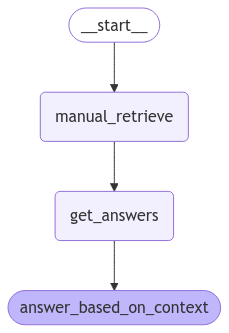

In [21]:
# let's visualize the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
result = graph.invoke({"raw_input": "На Python быстро разрабатывать?"})

print(f"Context: {result['qna_context']}\n\n")
print(f"Answer: {result['answer']}")

Context: ['По нашим оценкам, по сравнению с традиционными Java/C#, разработка быстрее в десятки раз, но производительность решений может быть меньше на порядок (если не используются специальные библиотеки наподобие numpy, sklearn и других)', 'Удобнее всего работать на Linux, в среде VsCode или JupyterLab.', 'На Windows используйте `myenv\\Scripts\\activate`, на macOS/Linux - `source myenv/bin/activate`.', 'Python - это высокоуровневый язык программирования общего назначения с простым синтаксисом.', 'Он широко используется в веб-разработке, анализе данных, искусственном интеллекте и автоматизации.']


Answer: ДА, по нашим оценкам, по сравнению с традиционными Java/C#, разработка на Python быстрее в десятки раз, но производительность решений может быть меньше на порядок (если не используются специальные библиотеки).

Спасибо за вопрос!


In [23]:
vector_store.similarity_search("Быстрая разработка на Python")

[Document(id='5f3d8be2-de3e-49a6-ab58-0ca478fe3d48', metadata={'source': 'local_qna'}, page_content='Насколько быстрее Python в разработке?'),
 Document(id='51e6fba9-c69b-4ff0-9b51-c9864fd08b60', metadata={'source': 'local_qna'}, page_content='Где удобнее всего работать с Python?'),
 Document(id='dcf14c91-fa55-49f1-841b-e7859f4ba142', metadata={'source': 'local_qna'}, page_content='Как активировать виртуальную среду в Python?'),
 Document(id='5e6de2eb-0ad4-454d-874f-5c83aa886db0', metadata={'source': 'local_qna'}, page_content='Что такое Python?')]